# Traffic sign recognition - Nerual Net

In [1]:
import numpy as np
np.random.seed(123)  # for reproducibility

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from sklearn import model_selection

from matplotlib import pyplot as plt
from imageio import imread # Need 'Imageio' 'Pillow' packages
import cv2

from math import floor, ceil
import os

import h5py

Using TensorFlow backend.


## Load data from German traffic sign database

In [2]:
main_folder_path = "./German traffic sign dataset" + "/GTSRB_Training" + "/"

csv_content = [] # One numpy array per folder
                 # Each numpy array x: image y: proprierties

# Iterate over all subfolders to read the CSV file of each class
for i in range(43):
    train_dataset_path = main_folder_path + "{:05.0f}".format(i) + "/"
    f_name = train_dataset_path + "GT-" + "{:05.0f}".format(i) + ".csv"
    csv_content.append(np.genfromtxt(f_name, delimiter=';', skip_header=1, dtype=str))
print(csv_content[0][1,:])

['00000_00001.ppm' '30' '30' '5' '5' '25' '25' '0']


In [3]:
# Load the images and respective class

image = []
img_num = 0
labels = np.empty(0)

for i in range(43):
    image_class = []
    train_dataset_path = main_folder_path + "{:05.0f}".format(i) + '/'
    for label_name in enumerate(csv_content[i][:,0]):
        image_class.append(imread(train_dataset_path + label_name[1])[:,:,0]) # Adding image
        labels = np.append(labels, i) # Appending image class based on folder
        img_num += 1
    image.append(image_class)

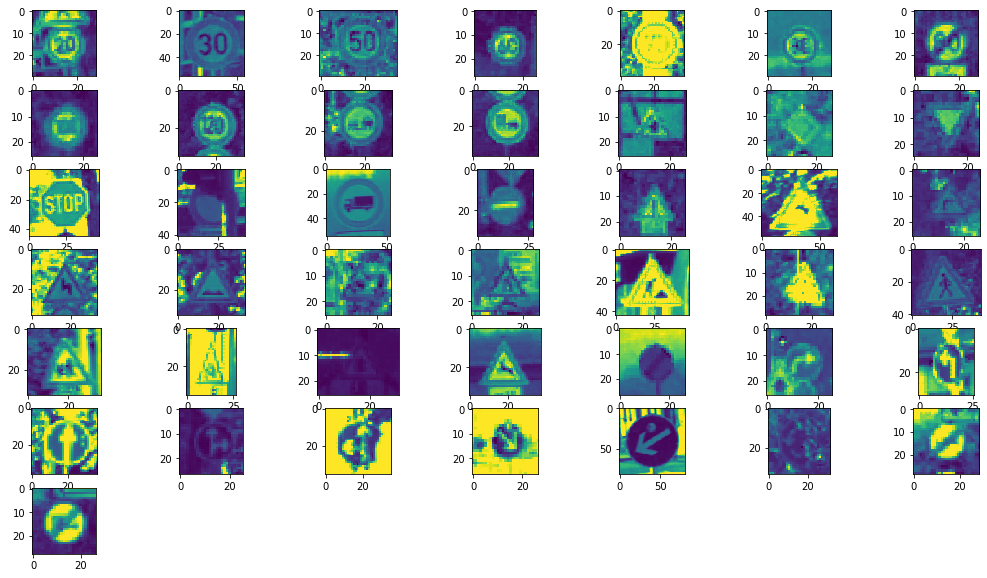

In [4]:
# Print the first image in every class
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(nrows=7, ncols=7)

for i in enumerate(image):
    ax0 = fig.add_subplot(gs[i[0]//7, i[0]%7])
    ax0.imshow(i[1][0])
    
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

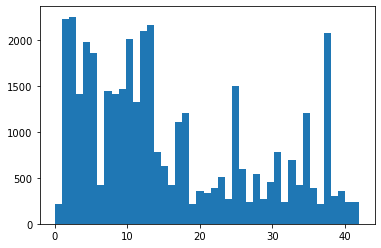

In [5]:
# Histogram of class population
plt.hist(labels, len(image))
plt.show

## Adapting the images

In [6]:
# Reshape training set
x_size = 32
y_size = 32
img_train = np.empty((img_num, x_size, y_size))

elaborated = 0

for image_set in enumerate(image):
    for image_array in enumerate(image_set[1]):
        # Cutting the image to match the content
        x2 = int(csv_content[image_set[0]][image_array[0], 5]) 
        x1 = int(csv_content[image_set[0]][image_array[0], 3])
        y2 = int(csv_content[image_set[0]][image_array[0], 6]) 
        y1 = int(csv_content[image_set[0]][image_array[0], 4])
        size = max(x2-x1, y2-y1)
        # Padding to have square images
        padded = np.pad(np.asarray(image_array[1][x1:x2, y1:y2]), \
                        ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                         (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
        # Reshaping the image to match the selected dimension
        reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
        # Copying the image inside the output array
        np.copyto(img_train[elaborated,:,:], reshaped)
        # Showing result
        #plt.imshow(img_train[elaborated,:,:])
        #plt.show()
        #Images should be one after another to train the model
        elaborated += 1

In [7]:
# Reshaping the train data to have a correct fit input
print(img_train.shape)
img_train_rsh = np.reshape(img_train, (img_train.shape[0], img_train.shape[1], img_train.shape[2],1))
print(img_train_rsh.shape)

(39209, 32, 32)
(39209, 32, 32, 1)


In [8]:
# Split train and validation data from the train dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split(img_train_rsh, labels, test_size=0.25)
print(x_train.shape[0], x_test.shape[0], y_train.shape[0], y_test.shape[0])

29406 9803 29406 9803


In [9]:
# Prepare ground truth for classification
print(y_train.shape)
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, len(image))
Y_test = to_categorical(y_test, len(image))
print(Y_train.shape)

(29406,)
(29406, 43)


## Convolutional network model - SOA

In [10]:
model = Sequential()
model.add(Conv2D(200, (7,7), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(200, (4,4), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(200, (4,4), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(43, activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, Y_train, batch_size=50, epochs=15, verbose=1)

Epoch 1/15
23250/29406 [======================>.......] - ETA: 1:16 - loss: 1.1801 - accuracy: 0.7354

KeyboardInterrupt: 

## Testing and saving the model

In [ ]:
y_test_prob = model.predict(x_test)
y_test = np.argmax(y_test_prob)

test_loss, test_acc = model.evaluate(x_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
model.save("./Models/model.h5")
print("Saved model to disk")

# Prepare test data

In [ ]:
# Preparing data to be sent to MCU for validation from CV test set

to_test = np.reshape(x_test[:,:,:], (-1,1024))

with open("./Test_data/image_arranged_cv.csv", "w") as f:
    np.savetxt(f, to_test[1:10,:], delimiter=',')
    
with open("./Test_data/image_annotation_cv.csv", "w") as f:
    np.savetxt(f, Y_test[1:10,:], delimiter=',')
    

In [ ]:
# Adapting test data to network input dimension from data dataset

main_folder_path = "./German traffic sign dataset"
test_dataset_path = main_folder_path + "/GTSRB_Testing" + "/GT-final_test.csv"

test_csv = (np.genfromtxt(test_dataset_path, delimiter=';', skip_header=1, dtype=str))

image_test = []

for name_img in test_csv:
    image_test.append(imread("./German traffic sign dataset" + "/GTSRB_Testing" + "/" + name_img[0])[:,:,0])
    
plt.imshow(image_test[0])
plt.show()     

# Count total number of images:
img_test_num = len(image_test)
                                 
# Reshape test set
img_test = np.empty((img_num, x_size, y_size))

# Handling the classes
test_annotation = to_categorical(test_csv[:, 7], len(image))

for image_set in enumerate(image_test):
    # Cutting the image to match the content
    x2 = int(test_csv[image_set[0], 5]) 
    x1 = int(test_csv[image_set[0], 3])
    y2 = int(test_csv[image_set[0], 6]) 
    y1 = int(test_csv[image_set[0], 4])
    size = max(x2-x1, y2-y1)
    # Padding to have square images
    padded = np.pad(np.asarray(image_set[1][x1:x2, y1:y2]), \
                    ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                     (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
    # Reshaping the image to match the selected dimension
    reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
    # Copying the image inside the output array
    np.copyto(img_test[image_set[0],:,:], reshaped)

In [ ]:
to_test = np.reshape(img_test[:,:,:], (-1,1024))

with open("./Test_data/image_arranged.csv", "w") as f:
    np.savetxt(f, to_test[1:10,:], delimiter=',')
    
with open("./Test_data/image_annotation.csv", "w") as f:
    np.savetxt(f, test_annotation[1:10,:], delimiter=',')